In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

In [21]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.nn import GCNConv, Set2Set, GNNExplainer
import torch_geometric.transforms as T
import torch
import torch.nn.functional as F
import os

import matplotlib.pyplot as plt
from dgl.data import BACommunityDataset
import networkx as nx
import torch_geometric
import dgl
from copy import deepcopy


In [202]:
from src.model import *
from src.data import *
from src.explainer import *
from src.plot import *
from src.modify import *
from src.protgnn import *

In [6]:
ba_dataset = get_dataset("BAShapes")

Done loading data from cached files.


/rds/user/njr61/hpc-work/anaconda3/envs/gnn/lib/python3.9/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [7]:
num_classes = len(set([int(i) for i in ba_dataset.y]))
num_features = ba_dataset.x.shape[-1]

In [8]:
epochs = 3000
dim = 20

## GCExplainer

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(num_features=num_features, dim=dim, num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)


In [10]:
model = train_model(epochs,model,device,ba_dataset,optimizer,test_model)

[Train_loss:0.386930 Train_acc: 0.9482, Test_acc: 0.8143]: 100%|█| 3000/300


In [11]:
gce_explainer = GCExplainer()

In [12]:
gce_explainer.learn_prototypes(model,ba_dataset)

/rds/user/njr61/hpc-work/anaconda3/envs/gnn/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [13]:
gce_explainer.get_prediction(model,ba_dataset)

array([2, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 3, 0, 3, 0,
       1, 3, 1, 0, 0, 0, 1, 1, 1, 0, 0, 3, 1, 0, 0, 0, 0, 2, 1, 0, 0, 3,
       3, 0, 0, 1, 1, 1, 0, 0, 2, 1, 2, 0, 3, 0, 3, 2, 1, 1, 0, 0, 0, 1,
       1, 2, 1, 0, 2, 3, 1, 1, 1, 2, 1, 1, 1, 0, 1, 2, 2, 1, 0, 3, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 3, 2, 2, 0, 1, 3, 2, 0, 3, 2, 0, 0, 0, 3,
       1, 1, 2, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 3, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 3, 1, 3, 0, 2, 1, 3])

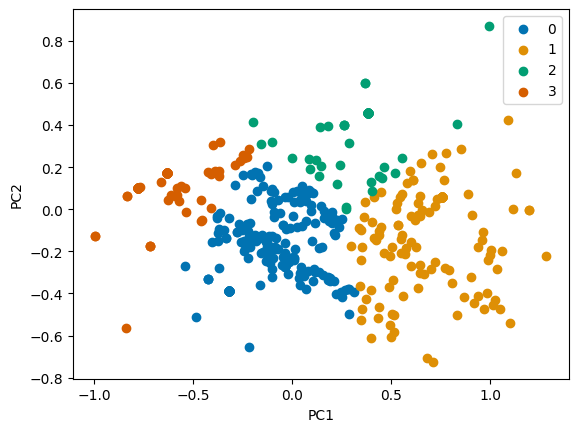

In [14]:
plot_kmeans_clusters(gce_explainer.kmeans,gce_explainer.initial_activations)

### Replicate the paper so we can predict activations from adjacency matrix

In [59]:
num_nodes = ba_dataset.num_nodes
A = np.zeros((num_nodes,num_nodes))

In [62]:
for a,b in ba_dataset.edge_index.T:
    A[a,b] = A[b,a] = 1

In [66]:
identity = np.eye(num_nodes)
A_squiggle = A+identity

In [118]:
D_squiggle = np.diag(np.sum(A_squiggle, axis=1))

In [119]:
W_0 = model.conv1.lin.weight

In [120]:
X_0 = ba_dataset.x
edge_index = ba_dataset.edge_index

In [121]:
H_0 = model.conv1(X_0, edge_index)

In [122]:
D_half = np.zeros(D_squiggle.shape)
np.fill_diagonal(D_half, 1/ (D_squiggle.diagonal()**0.5))

In [179]:
D_quarter = np.zeros(D_squiggle.shape)
np.fill_diagonal(D_quarter, 1/ (D_squiggle.diagonal()**0.25))

In [123]:
H_pred = (D_half).dot(A_squiggle).dot(D_half).dot(X_0.detach().numpy()).dot(W_0.detach().numpy().T)

In [140]:
H_0

tensor([[ 5.1975e-01,  3.5031e-01, -3.0449e-08,  ..., -1.0585e-03,
          3.4940e-01,  6.2637e-01],
        [ 5.1975e-01,  3.5031e-01, -3.0449e-08,  ..., -1.0585e-03,
          3.4940e-01,  6.2637e-01],
        [ 5.1975e-01,  3.5031e-01, -3.0449e-08,  ..., -1.0585e-03,
          3.4940e-01,  6.2637e-01],
        ...,
        [ 8.0564e-01,  1.7948e-01, -4.0436e-08,  ..., -1.4369e-03,
          4.9817e-01,  9.4597e-01],
        [ 7.5349e-01,  2.1064e-01, -3.8615e-08,  ..., -1.3679e-03,
          4.7103e-01,  8.8767e-01],
        [ 5.8362e-01,  3.1214e-01, -3.2680e-08,  ..., -1.1431e-03,
          3.8264e-01,  6.9777e-01]], grad_fn=<AddBackward0>)

In [139]:
H_pred+model.conv1.bias.detach().numpy()

array([[ 5.52536381e-01,  3.30718256e-01, -3.15938711e-08, ...,
        -1.10190215e-03,  3.66460931e-01,  6.63018693e-01],
       [ 5.52536381e-01,  3.30718256e-01, -3.15938711e-08, ...,
        -1.10190215e-03,  3.66460931e-01,  6.63018693e-01],
       [ 5.52536381e-01,  3.30718256e-01, -3.15938711e-08, ...,
        -1.10190215e-03,  3.66460931e-01,  6.63018693e-01],
       ...,
       [ 6.02913925e-01,  3.00616388e-01, -3.33538904e-08, ...,
        -1.16858290e-03,  3.92676297e-01,  7.19337264e-01],
       [ 6.19096516e-01,  2.90946878e-01, -3.39192549e-08, ...,
        -1.19000251e-03,  4.01097361e-01,  7.37428268e-01],
       [ 5.00233450e-01,  3.61970591e-01, -2.97665852e-08, ...,
        -1.03267291e-03,  3.39243635e-01,  6.04547674e-01]])

In [199]:
A_predicted = get_adjacency_power(A_squiggle,D_half,2,10)

In [200]:
A_predicted

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.30555556, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [198]:
np.linalg.matrix_power(D_half.dot(A_squiggle).dot(D_half),2)[10]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.30555556, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [212]:
move_direction = get_movement_direction(gce_explainer.kmeans.cluster_centers_,2,activations_test[idx])

In [213]:
distances = np.linalg.norm(gce_explainer.kmeans.cluster_centers_ - (activations_test[idx]+move_direction), axis=1)
np.argmin(distances)

0

### Test the impact of the targeted attack

In [38]:
idx = 560

In [45]:
activations_test, clusters_test = gce_explainer.get_prediction(model,identity(ba_dataset),test=False, get_activations=True)

In [47]:
np.linalg.norm(activations_test[idx]-gce_explainer.kmeans.cluster_centers_[2])

0.06063030023128682

In [48]:
clusters_test[idx]

2

In [144]:
new_dataset = targeted_attack(deepcopy(ba_dataset),gce_explainer,model,idx,1)

In [50]:
activations_test, clusters_test = gce_explainer.get_prediction(model,identity(new_dataset),test=False, get_activations=True)

In [51]:
np.linalg.norm(activations_test[idx]-gce_explainer.kmeans.cluster_centers_[2])

0.06063030023128682

In [52]:
clusters_test[idx]

2